In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import torch
import torch.nn as nn
import torch.autograd as ag

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cpu


In [2]:
# imporve with GPU
# https://researchcomputing.princeton.edu/support/knowledge-base/jupyter

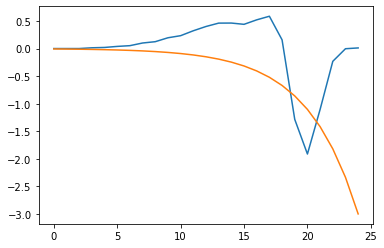

In [3]:
### Simple RSNN model
# kernels
kc = -np.array([ 0.0, 0.0, 0.0, -0.01368046, -0.01986828,
 -0.03867417, -0.05218188, -0.10044614, -0.12434759, -0.19540891, -0.23327453,
 -0.32255702, -0.40001292, -0.46124429, -0.46235415, -0.43928836, -0.52066692,
 -0.58597496, -0.15804368,  1.2849799,   1.91338741,  1.10402054,  0.23188751,
  0.00331092, -0.0111924, ])
lk = len(kc)
xx = np.arange(0,lk)
kh = 3*np.flip(-np.exp(-xx/4))
plt.plot(kc)
plt.plot(kh)

# weights for the network
N = 3
ww = np.random.randn(N,N)*1
vv = np.random.randn(N,1)
ww = ww + vv@vv.T*3.
W = np.zeros((N,N,lk))
for ii in range(N):
    for jj in range(N):
        if ii==jj:
            W[ii,jj,:] = kh
        else:
            W[ii,jj,:] = ww[ii,jj]*kc/np.sqrt(N)
            
# nonlinearity and spiking process
def NL(x,th):
    return (x-th)/th
def sig(x):
    return 1/(1+np.exp(-x))
def Binom(x):
    spk = np.zeros(len(x))
    P = np.random.rand(len(x))
    spk[x>P] = 1
    return spk

In [4]:
### try with ground-truth basis functon here...

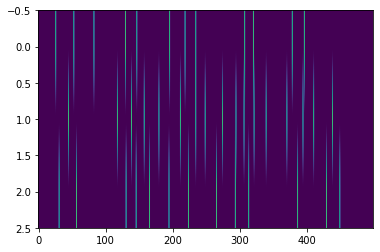

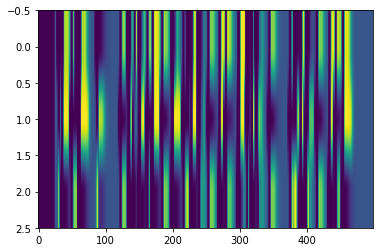

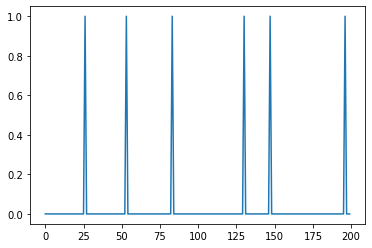

In [5]:
# GLM circuit dynamics
lt = 500
dt = 0.1
vth = 0.1
zt = np.zeros((N,lt))
rt = zt*1
for tt in range(lk,lt):
    vt = np.einsum('ijk,jk->i', W, zt[:,tt-lk:tt])
    rt[:,tt] = sig(NL(vt,vth))*dt
    zt[:,tt] = Binom(rt[:,tt])

plt.imshow(zt,aspect='auto')
plt.figure()
plt.imshow(rt,aspect='auto')
plt.figure()
plt.plot(zt[0,:200])

In [6]:
### CNN with spike observation as input and output as spike rate
#...maybe try RNN!
### co-training with spike likelihodd that also meets the CNN output rate

In [6]:
def GLM_circuit(W, lt=500, dt=0.1, vth=0.1):
    """
    Given the neuron-time tensor for coupling between neurons, simulate Poisson spike-trains
    with the time length lt, time step dt, and threshold vth
    return the spike train zt and spike rate rt, with T x N neurla data
    """
    zt = np.zeros((N,lt))
    rt = zt*1
    for tt in range(lk,lt):
        vt = np.einsum('ijk,jk->i', W, zt[:,tt-lk:tt])
        rt[:,tt] = sig(NL(vt,vth))*dt
        zt[:,tt] = Binom(rt[:,tt])
    return zt.T, rt.T

In [8]:
# Define networks

class CTRNN(nn.Module):
    """Continuous-time RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms. 
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 1
        if dt is None:
            alpha = .1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

#         self.input2h = nn.Linear(input_size, hidden_size)  # Identity for feedback ??????
        self.input2h = nn.Identity()
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.sigmoid(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        
        # Add an output layer
#         self.fc = nn.Linear(hidden_size, output_size)  # should be identiy readout as well ??????
        self.fc = nn.Identity()
        self.readout_nl = nn.ReLU()

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.readout_nl( self.fc(rnn_output) )
        return out, rnn_output


In [9]:
class RSNN(nn.Module):
    """
    Recurrent spiking neural network
    input the spiking data
    ouput the GLM estimated spike rate, conditioned on parameters
    parameters are weights on the basis that for coupling kernels
    """
    def __init__(self, N, Basis):
        super().__init__()
        ### initialize coefficient in the model
        nb = Basis.shape[0]
        params = torch.distributions.Uniform(-0.5, 0.5).sample((N,N,nb))
        ### make it into parameter for optimization
        self.params = nn.Parameter(params, requires_grad=True)
        self.N = N  # N neurons in the circuit
        self.B = Basis  # basis function for the kernels
#         self.Jt = torch.einsum('ijk,kl->ijl', self.params, Basis)  # N x N x tau tensor for coupling
        self.th = 0.1  # thresholding
    
    def NL(self, x):
        return (x-self.th)/self.th
    def sig(self, x):
        return 1/(1+torch.exp(-x))
    def Binom(self, x):
        spk = torch.zeros(len(x))
        P = torch.rand(len(x))
        spk[x>P] = 1
        return spk

    def forward(self, X):
        Jt = torch.einsum('ijk,kl->ijl', self.params, self.B)  # N x N x tau tensor for coupling
        lt = X.shape[0]  # T x batch x N data
        nb = X.shape[1]
        rit = torch.zeros_like(X)
#         zt = torch.zeros_like(X)  # zt = X.clone()
        lk = self.B.shape[1]  # nb x lk basis functions
        for bb in range(nb):
            for tt in range(lk,lt):
                vt = torch.einsum('ijk,jk->i', Jt, X[tt-lk:tt,bb,:].squeeze().T)
                rit[tt,bb,:] = self.sig(self.NL(vt))*dt
#             zt[tt,:] = self.Binom(rit[tt,:])
        return rit
    
def spk_rate_loss(spk,rt):
    reg = 0  # regularization if needed
    LL = torch.sum(spk*torch.log(rt+10**-10) - rt) - reg  #Poisson log-likelig=hood
    return -LL

# log-likelihood function
def basis_function(nkbins, nBases):
    """
    Raised cosine basis function to tile the time course of the response kernel
    nkbins of time points in the kernel and nBases for the number of basis functions
    """
    #nBases = 3
    #nkbins = 10 #binfun(duration); # number of bins for the basis functions
    ttb = np.tile(np.log(np.arange(0,nkbins)+1)/np.log(1.4),(nBases,1))  #take log for nonlinear time
    dbcenter = nkbins / (nBases+int(nkbins/3)) # spacing between bumps
    width = 5.*dbcenter # width of each bump
    bcenters = 1.*dbcenter + dbcenter*np.arange(0,nBases)  # location of each bump centers
    def bfun(x,period):
        return (abs(x/period)<0.5)*(np.cos(x*2*np.pi/period)*.5+.5)  #raise-cosine function formula
    temp = ttb - np.tile(bcenters,(nkbins,1)).T
    BBstm = [bfun(xx,width) for xx in temp] 
    #plt.plot(np.array(BBstm).T)
    BBstm = np.array(BBstm).copy()
    return np.fliplr(BBstm)

In [10]:
batch_size = 5
seq_len = lt*1  # sequence length, time vector
input_size = N*1  # input dimension, number of neurons

# basis function for kernel
nk = 4
basis_np = basis_function(lk, nk)
Basis = torch.tensor(basis_np.copy(), dtype=torch.float32, device=device)

In [11]:
### record GLM circuit dynamics data
inpts = np.zeros((lt, batch_size, input_size))
outps = inpts*1
for bb in range(batch_size):
    inpts[:,bb,:], outps[:,bb,:] = GLM_circuit(W, lt, dt, vth)
dataset = inpts, outps

In [41]:
### training
import time

# Instantiate the network and print information
hidden_size = N*1
output_size = N*1
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=dt)
glm_model = RSNN(N, Basis).to(device)

print(net)
# Use Adam optimizer
params = list(net.parameters()) + list(glm_model.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
# opt_glm = torch.optim.Adam(glm_model.parameters(), lr=0.001)
poi_loss = nn.PoissonNLLLoss()
mse_loss = nn.MSELoss()
eps = 1e-10

running_loss = 0
running_acc = 0
start_time = time.time()
# Loop over training batches
print('Training network...')
for i in range(500):
    # Generate input and target, convert to pytorch tensor
    inpt_spk, targ_rt = dataset
    inpt_spk = torch.from_numpy(inpt_spk).type(torch.float)
    targ_rt = torch.from_numpy(targ_rt).type(torch.float)
    
    ### "GINN" framework tests
    # boiler plate pytorch training:
    optimizer.zero_grad()   # zero the gradient buffers
    
    rnn_output,_ = net(inpt_spk)
    loss_rnn = poi_loss(torch.log(rnn_output + eps), targ_rt)
#     loss_rnn = mse_loss( rnn_output, targ_rt )  #simplify with know rate first...
    # GLM constraints
    glm_rt = glm_model(inpt_spk[:-1,:,:])
    loss_glm = mse_loss( rnn_output[1:,:,:], glm_rt )  # 'physical informed' GLM prediction
    
    ### traditional GLM MLE method
#     glm_rt = glm_model(inpt_spk)
#     loss_glm = poi_loss( torch.log(glm_rt+eps) , inpt_spk )
#     loss_glm = mse_loss( glm_rt , targ_rt )  #cheeting with ground-truth test
    
    # joint loss
    loss = loss_glm + loss_rnn*10
    loss.backward()
    optimizer.step()    # Does the update
    
#     opt_glm.zero_grad()
#     loss_glm.backward()
#     opt_glm.step()

    # Compute the running loss every 100 steps
    running_loss += loss.item()
    if i % 100 == 99:
        running_loss /= 100
        print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
            i+1, running_loss, time.time() - start_time))
        running_loss = 0

RNNNet(
  (rnn): CTRNN(
    (input2h): Identity()
    (h2h): Linear(in_features=3, out_features=3, bias=True)
  )
  (fc): Identity()
  (readout_nl): ReLU()
)
Training network...
Step 100, Loss 4.6780, Time 86.8s
Step 200, Loss 4.2411, Time 175.4s
Step 300, Loss 3.8968, Time 265.4s
Step 400, Loss 3.6150, Time 352.7s
Step 500, Loss 3.3788, Time 439.0s


In [42]:
# glm_model = RSNN(N, Basis).to(device)
# glm_rt = glm_model(inpt_spk)
# loss_glm = poi_loss( torch.log(glm_rt+eps) , inpt_spk )
# loss_glm
# plt.imshow(glm_rt[:,0,:].detach().numpy().T, aspect='auto',interpolation='none')

array([[0.02950116, 0.05466187, 0.07613699, ..., 0.20018554, 0.20023638,
        0.20029148],
       [0.04474992, 0.08401053, 0.11847132, ..., 0.38192728, 0.38088316,
        0.37995374],
       [0.03950464, 0.0735627 , 0.10293557, ..., 0.28706765, 0.28689277,
        0.2867519 ]], dtype=float32)

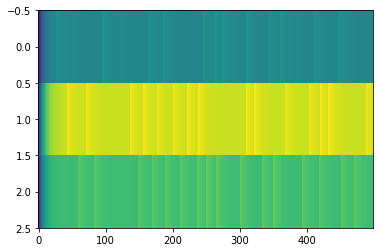

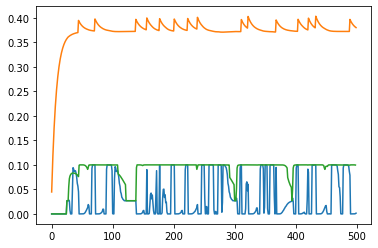

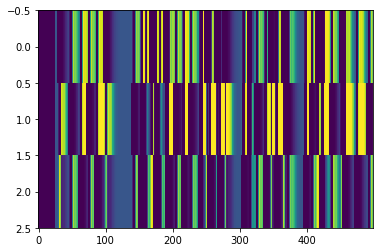

In [43]:
### test after training
neur, trial = 1, 4
inpt = torch.from_numpy(inpts[:, trial, :]).type(torch.float)
action_pred, rnn_activity = net(inpt)
plt.imshow(action_pred[:, 0, :].detach().numpy().T, aspect='auto',interpolation='none')
plt.figure()
plt.plot(targ_rt[:, trial, neur].detach().numpy().T)
plt.plot(action_pred[:, 0, neur].detach().numpy())
plt.plot(glm_rt[:, trial, neur].detach().numpy())
plt.figure()
plt.imshow(targ_rt[:,trial,:].T, aspect='auto',interpolation='none')
action_pred[:, 0, :].detach().numpy().T

<Figure size 432x288 with 0 Axes>

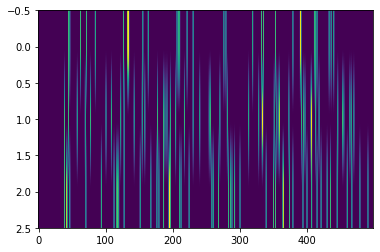

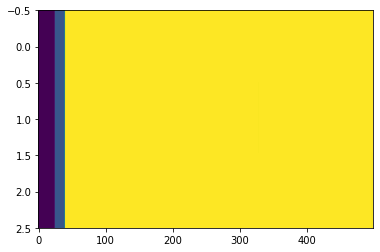

<Figure size 432x288 with 0 Axes>

In [44]:
## spiking tests
W_par = glm_model.params.detach().numpy()
W_inf = np.einsum('ijk,kl->ijl', W_par, Basis)
z_inf, r_inf = GLM_circuit(W_inf, lt, dt, vth)
plt.imshow(z_inf.T,aspect='auto')
plt.figure()
plt.imshow(r_inf.T,aspect='auto')
plt.figure()

## CNN method

In [199]:
class ApproximatorNet(nn.Module):
    def __init__(self, input_size: int = 3, output_size: int = 3, hidden_layers: int = 5, hidden_nodes: int = 10) -> None:
        """
            Builds an neural network to approximate the value of the differential equation
            input_size must be set to number of parameters in the function f for ODE this is 1
            output_size number of values output by the function for ODE this is 1
        """
        super().__init__()
        
        self.inputs  = nn.Linear(input_size, hidden_nodes)
        self.model   = nn.ModuleList([nn.Linear(hidden_nodes, hidden_nodes)] * hidden_layers)
        self.outputs = nn.Linear(hidden_nodes, output_size)
        
        self.activation = nn.Sigmoid() # Can be either tanh or sigmoid, ReLU is not differentiable (at 0)
    
    def _apply_model(self, x: torch.Tensor) -> torch.Tensor:
        """
            Runs the input through the hidden layers
        """
        for layer in self.model:
            x = self.activation(layer(x))
        return x

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t = self.activation(self.inputs(t))
        t = self._apply_model(t)
        t = self.activation(self.outputs(t))
        return t

In [ ]:
class RSNN_mle(nn.Module):
    def __init__(self, N, Basis):
        super().__init__()
        ### initialize coefficient in the model
        nb = Basis.shape[0]
        params = torch.distributions.Uniform(-0.5, 0.5).sample((N,N,nb))
        ### make it into parameter for optimization
        self.params = nn.Parameter(params, requires_grad=True)
        self.N = N  # N neurons in the circuit
        self.B = Basis  # basis function for the kernels
        self.Jt = torch.einsum('ijk,kl->ijl', params, Basis)  # N x N x tau tensor for coupling
        self.th = 0.1  # thresholding
    
    def NL(self, x):
        return (x-self.th)/self.th
    def sig(self, x):
        return 1/(1+torch.exp(-x))
    def Binom(self, x):
        spk = torch.zeros(len(x))
        P = torch.rand(len(x))
        spk[x>P] = 1
        return spk

    def forward(self, X):
        lt = X.shape[0]  # X as N x T data
        rit = torch.zeros_like(X)
#         zt = torch.zeros_like(X)
#         zt = X.clone()
        lk = self.B.shape[1]  # nb x lk basis functions
        for tt in range(lk,lt):
            vt = torch.einsum('ijk,jk->i', self.Jt, X[tt-lk:tt,:].T)
            rit[tt,:] = self.sig(self.NL(vt))
#             zt[tt,:] = self.Binom(rit[tt,:])
        return rit

torch.Size([4, 25])

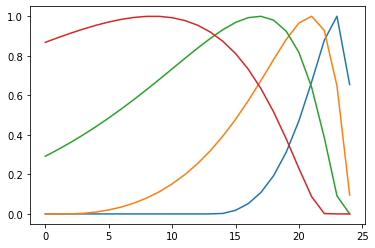

In [209]:
# test = np.einsum('ijk,kl->ijl', np.random.randn(3,3,4), basis_np)

torch.distributions.Uniform(-0.5, 0.5).sample((N,N,4)).shape
basis_np = basis_function(lk, nk)
plt.plot(basis_np.T)
Basis.shape

In [210]:
### pre-process data
Nneur, lt_data = zt.shape[0], zt.shape[1]
time = np.arange(0,lt,1)
x_data = np.repeat(time[None,:],Nneur,axis=0)

# for pytorch tensors
x_data_t = torch.tensor(x_data.T, dtype =torch.float32, device=device)
y_data_t = torch.tensor(zt.T, dtype =torch.float32, device=device) #observed spikes

# setup time and 'space' vector
x_physics = torch.linspace(0, lt_data, lt_data, requires_grad=True, device=device, dtype=torch.float32).reshape(-1,1)
x_physics = x_physics.repeat(1,Nneur)

# basis function for kernel
nk = 4
basis_np = basis_function(lk, nk)
Basis = torch.tensor(basis_np.copy(), dtype=torch.float32, device=device)

torch.Size([500, 3])

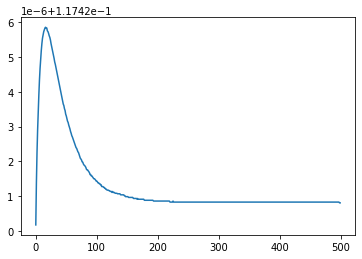

In [213]:
def t2n(x):
    return x.detach().numpy()

spk,rt = y_data_t, lamb_pred
LL = torch.sum(spk*torch.log(rt) - rt)
# plt.imshow(t2n(lamb_pred).T,aspect='auto')
plt.plot(t2n(lamb_pred)[:,2])
# spk_rate_loss(y_data_t, lamb_pred)
LL
x_data_t.shape

In [217]:
### PINN naive tests ###

### hyperparameters
EPOCHS = 5_000
LR = 1e-3
eps = 1e-10  # stable log

### setup models and optimization methods
model = ApproximatorNet(hidden_layers=5, hidden_nodes=15).to(device)

glm_model = RSNN_mle(N, Basis).to(device)
params = list(model.parameters()) + list(glm_model.parameters())
# params = model.parameters()

optim = torch.optim.Adam(params, lr=LR)

data_loss = nn.MSELoss()
glm_loss = nn.PoissonNLLLoss()
# glm_loss = nn.MSELoss() #nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    optim.zero_grad()

    ### Data loss
    lamb_pred = model(y_data_t)#(np.repeat(x_data_t,2,1))
#     loss_u = spk_rate_loss(y_data_t, lamb_pred)  #data_loss(y_pred, y_data_t)
    loss_u = glm_loss(torch.log(lamb_pred+eps) , y_data_t)

    ### GLM loss  ############### have to figure this out!! ##########################3
    u = model(y_data_t)#(x_physics)   ## NN predicted spike rate
#     draw_spk = torch.bernoulli(u)  ## draw spike from predicted rate
    glm_rt = glm_model(y_data_t)   ## predicted rate from the GLM network given input
    loss_glm = torch.mean((u - glm_rt)**2)#data_loss(u, glm_rt)
#     loss_glm = spk_rate_loss(glm_spk, u)
#     loss_glm = glm_loss(torch.log(u+eps) , glm_spk)
    ########################################### maybe a model fit rather than generative process?
    ### with rate (lambda) and spikes (n) from NN, compute lambda - g(K*n) = 0 as a constraint
    
    ### loss for physics-informed neural-network
    loss = loss_u + 10*loss_glm
    loss.backward(retain_graph=True)
    optim.step()
    
    ### print progress
    if epoch % 1000 == 0:
        print(f"Epochs = {epoch} of {EPOCHS}, Loss = {float(loss):.7f}, loss_u={float(loss_u):.5f}, loss_glm={float(loss_glm):.5f}")
#         print('current param estimation:', glm_model.params)

Epochs = 0 of 5000, Loss = 1.6497313, loss_u=0.48026, loss_glm=0.11695
Epochs = 1000 of 5000, Loss = 0.4504508, loss_u=0.20771, loss_glm=0.02427
Epochs = 2000 of 5000, Loss = 0.4503962, loss_u=0.20727, loss_glm=0.02431
Epochs = 3000 of 5000, Loss = 0.4503940, loss_u=0.20726, loss_glm=0.02431
Epochs = 4000 of 5000, Loss = 0.4503905, loss_u=0.20726, loss_glm=0.02431


In [218]:
torch.max(u)

tensor(0.2711, grad_fn=<MaxBackward1>)

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       ...,
       [8.2309109e-01, 2.5139534e-01, 5.7779891e-07],
       [8.2309109e-01, 2.5139534e-01, 5.7779891e-07],
       [8.2309109e-01, 2.5139534e-01, 5.7779891e-07]], dtype=float32)

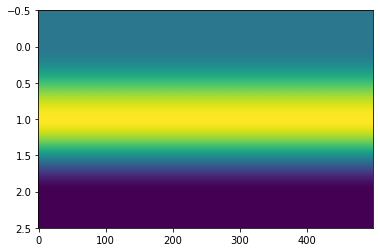

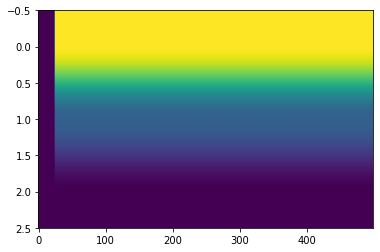

In [219]:
model.eval()
# y_pred = model(torch.tensor(x, dtype = torch.float32, device=device).reshape(-1,1))
y_pred = model(x_data_t)
y_pred_np = y_pred.detach().cpu().numpy()
plt.imshow(y_pred_np.T,aspect='auto')

glm_spk = glm_model(y_pred)
spk_pred_np = glm_spk.detach().cpu().numpy()
plt.figure()
plt.imshow(spk_pred_np.T,aspect='auto')

spk_pred_np

In [12]:
def circuit_design_matrix(spikes, Ks):
    """
    Given circuit spikes, construct design matrix with features being the values projected onto kernels in Ks
    spikes: T x N (time by neurons)
    Ks: k x pad (k kernels with time window pad)
    Output: T x (Nxk) 
    """
    T, N = spikes.shape
    k, pad = Ks.shape
    
    Stimpad = np.concatenate((stimulus,np.zeros((pad,1))),axis=0)
    S = np.arange(-pad+1,1,1)[np.newaxis,:] + np.arange(0,T,1)[:,np.newaxis]
    Xstim = np.squeeze(Stimpad[S])
    Xstim_proj = np.array([Xstim @ Ks[kk,:] for kk in range(k)]).T
    
    if couple==0:
        X = np.concatenate((np.ones((T,1)), Xstim_proj),axis=1)
    elif couple==1:
        spkpad = np.concatenate((spikes,np.zeros((pad,N))),axis=0)
        Xhist = [np.squeeze(spkpad[S,[i]]) for i in range(0,N)]
        Xhist_proj = [np.array([Xhist[nn] @ Ks[kk,:] for kk in range (k)]).T for nn in range(N)]
        
        X = Xstim_proj.copy()
        X = np.concatenate((np.ones((T,1)), X),axis=1)
        for hh in range(0,N):
            X = np.concatenate((X,Xhist_proj[hh]),axis=1)
    return X

In [23]:
def design_matrix(idd, stim, spk, pad, cp_mode, basis_set=None):
    """
    idd:      int for neuron id
    stim:     TxN stimuli
    spk:      TxN spiking pattern
    pad:      int for kernel width, or number of weight parameters
    cp_mode:  binary indication for coupling or independent model
    basis_set:DxB, where D is the kernel window and B is the number of basis used
    """
    
    T, N = spk.shape  #time and number of neurons
    xx = stim[:,idd] #for input stimuli
    D = pad  #pad for D length of kernel
    y = spk  #spiking patterns
    #y = spk[:,idd] #for self spike
    #other_id = np.where(np.arange(N)!=idd)
    #couple = spk[:,other_id]
    
    if basis_set is None:
        if cp_mode==0:
            X = sp.linalg.hankel(np.append(np.zeros(D-2),xx[:T-D+2]),xx[T-D+1:]) #make design matrix
            X = np.concatenate((np.ones([T,1]),X),axis=1)  #concatenate with constant offset
        elif cp_mode==1:
            X = sp.linalg.hankel(np.append(np.zeros(D-2),xx[:T-D+2]),xx[T-D+1:])
            for nn in range(N):
                yi = y[:,nn]
                Xi = sp.linalg.hankel(np.append(np.zeros(D-2),yi[:T-D+2]),yi[T-D+1:])  #add spiking history
                X = np.concatenate((X,Xi),axis=1)
            X = np.concatenate((np.ones([T,1]),X),axis=1)
    else:
        basis = flipkernel(basis_set[:,1:].T)  #the right temporal order here!
        if cp_mode==0:
            X = sp.linalg.hankel(np.append(np.zeros(D-2),xx[:T-D+2]),xx[T-D+1:])
            X = X @ basis  #project to basis set
            X = np.concatenate((np.ones([T,1]),X),axis=1)
        elif cp_mode==1:
            X = sp.linalg.hankel(np.append(np.zeros(D-2),xx[:T-D+2]),xx[T-D+1:])
            X = X @ basis
            for nn in range(N):
                yi = y[:,nn]
                Xi = sp.linalg.hankel(np.append(np.zeros(D-2),yi[:T-D+2]),yi[T-D+1:])
                Xi = Xi @ basis
                X = np.concatenate((X,Xi),axis=1)
            X = np.concatenate((np.ones([T,1]),X),axis=1)      
        
    y = spk[:,idd]
    return y, X

def poisson_log_like(w,Y,X,dt,f=np.exp,Cinv=None):
    """
    Poisson GLM log likelihood.
    f is exponential by default.
    """
    # if no prior given, set it to zeros
    if Cinv is None:
        Cinv = np.zeros([np.shape(w)[0],np.shape(w)[0]])

    # evaluate log likelihood and gradient
    ll = np.sum(Y * np.log(f(X@w)) - f(X@w)*dt - sp.special.gammaln(Y+1) + Y*np.log(dt)) + 0.5*w.T@Cinv@w

    # return ll
    return ll

def flipkernel(k):
    """
    flipping kernel to resolve temporal direction
    """
    return np.squeeze(np.fliplr(k[None,:])) ###important for temporal causality!!!??

In [88]:
# Y, X = design_matrix(idd, xx, y, ww, 1)
# dd = X.shape[1]
# # %% inference test
# lambda_ridge = np.power(2.0,4)
# lambda_ridge = 0.0
# Cinv = lambda_ridge*np.eye(dd)
# Cinv[0,0] = 0.0 # no prior on bias
# # fit with MAP
# res = sp.optimize.minimize(lambda w: -poisson_log_like(w,Y,X,dtsp,np.exp,Cinv), np.zeros([dd,]),method='L-BFGS-B', tol=1e-4,options={'disp': True})
# w_map = res.xe